In [1]:
# Import necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd      # Data manipulation and analysis
import numpy as np       # Numerical computing
import requests          # Making HTTP requests to download data
import seaborn as sns    # Advanced data visualization
import matplotlib.pyplot as plt  # Basic data visualization

# Import machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Data preprocessing tools
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.feature_extraction.text import TfidfVectorizer  # Converting text to numerical features
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score  # Model evaluation metrics
from sklearn.ensemble import RandomForestClassifier  # Machine learning algorithm
from sklearn.utils import resample  # Tool for resampling data

# # Suppress warning messages to keep the output clean
# import warnings
# warnings.filterwarnings('ignore')

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3906
           1       0.97      0.96      0.97      3906

    accuracy                           0.97      7812
   macro avg       0.97      0.97      0.97      7812
weighted avg       0.97      0.97      0.97      7812



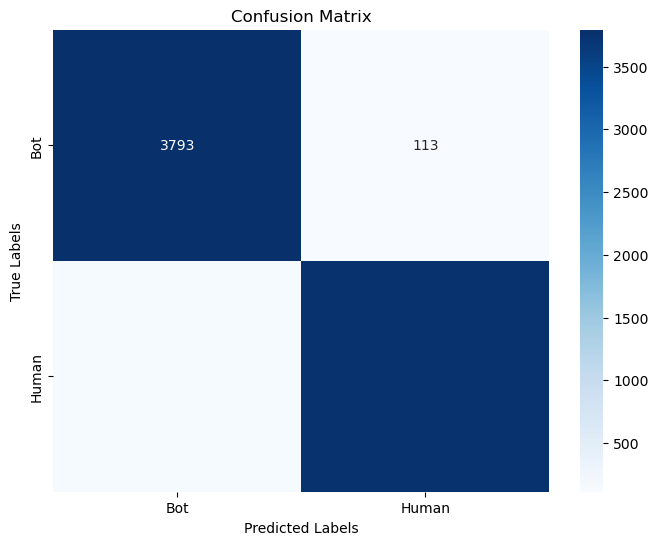

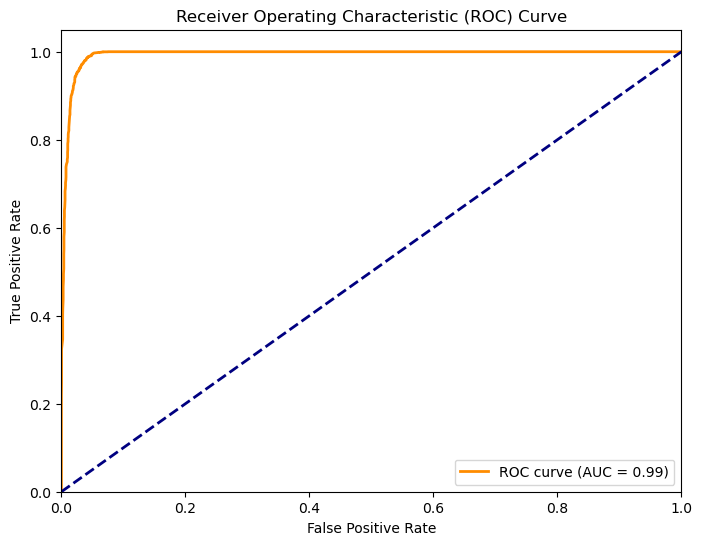

/Users/kylehe/miniconda3/envs/cs360-lab1/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


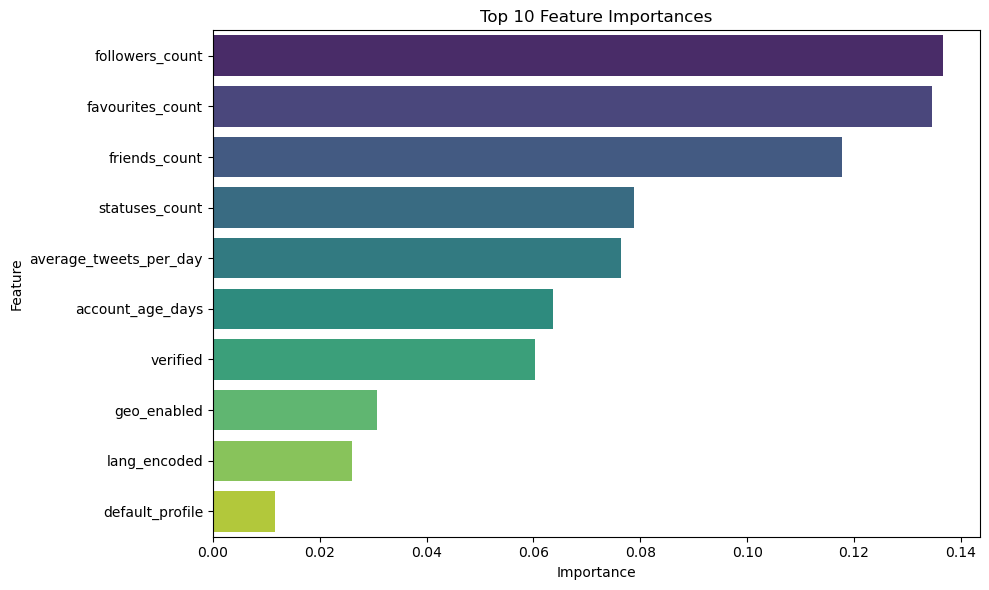

In [4]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load the dataset
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Preprocess the data inline (no separate functions)
df = df.dropna().reset_index(drop=True)

# Encode account_type as numerical
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])

# Convert boolean columns to integers
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode language
df['lang_encoded'] = le.fit_transform(df['lang'])

# Remove unnecessary columns
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'id', 'profile_background_image_url', 
    'profile_image_url', 'screen_name', 'location', 'account_type', 'lang'
])

# Convert text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_description_tfidf = tfidf_vectorizer.fit_transform(df['description']).toarray()

X_numerical = df_model.drop(columns=['account_type_encoded', 'description'], axis=1)
X_combined = np.hstack((X_numerical.to_numpy(), X_description_tfidf))
y = df_model['account_type_encoded']

# Balance the dataset
df_combined = pd.DataFrame(X_combined)
df_combined['account_type_encoded'] = y

df_majority = df_combined[df_combined['account_type_encoded'] == 1]  # Humans
df_minority = df_combined[df_combined['account_type_encoded'] == 0]  # Bots

df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_oversampled])

X_balanced = df_balanced.drop('account_type_encoded', axis=1).to_numpy()
y_balanced = df_balanced['account_type_encoded']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Train a Random Forest model
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=None,
    class_weight=None,
    bootstrap=False,
    random_state=42
)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bot", "Human"], yticklabels=["Bot", "Human"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Prepare feature names
numerical_feature_names = list(X_numerical.columns)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
all_feature_names = numerical_feature_names + tfidf_feature_names

# Feature Importance
feature_importance = rf.feature_importances_

# Sort features by importance and select top 10
indices = np.argsort(feature_importance)[::-1][:10]
top_feature_names = [all_feature_names[i] for i in indices]
top_feature_values = feature_importance[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feature_values, y=top_feature_names, orient='h', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [25]:
df_combined

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,account_type_encoded
0,0.0,0.0,4.0,1589.0,4.0,0.0,11041.0,0.0,7.870,1403.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,536.0,860.0,880.0,0.0,252.0,0.0,0.183,1379.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,3307.0,172.0,594.0,1.0,1001.0,0.0,0.864,1159.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,88.0,753678.0,116.0,1.0,4202.0,1.0,1.339,3138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,5522.0,291529.0,1581.0,1.0,14535.0,1.0,3.581,4059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25884,1.0,0.0,651.0,139.0,1105.0,0.0,340.0,0.0,0.084,4028.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25885,0.0,0.0,8839.0,1121486.0,605.0,1.0,24970.0,1.0,8.976,2782.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25886,1.0,0.0,399.0,85630.0,190.0,0.0,6174.0,1.0,2.226,2773.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25887,0.0,0.0,967.0,138.0,166.0,1.0,982.0,0.0,0.339,2899.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
df 

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,...,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,account_type_encoded,lang_encoded
0,0,2016-10-15 21:32:11,0,0,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,0,787405734442958848,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,0,7.870,1403,bot,0,9
1,1,2016-11-09 05:01:30,0,0,Photographing the American West since 1980. I ...,536,860,880,0,796216118331310080,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,0,0.183,1379,human,1,9
2,2,2017-06-17 05:34:27,0,0,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,1,875949740503859204,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,0,0.864,1159,human,1,9
3,4,2012-01-15 16:32:35,0,0,Loan coach at @mancity & Aspiring DJ,88,753678,116,1,464781334,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,1,1.339,3138,human,1,9
4,6,2009-07-08 22:22:59,0,0,"Co-Host of @TheTalkCBS, Judge on @DancingABC, ...",5522,291529,1581,1,55050269,...,http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1275104892...,carrieanninaba,14535,1,3.581,4059,human,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25884,37433,2009-08-08 13:11:15,1,0,"Role: Stock Taker. Past Roles: Nanny, Sales As...",651,139,1105,0,63963107,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5844684414...,butchsekab,340,0,0.084,4028,human,1,9
25885,37434,2013-01-05 21:35:37,0,0,KINGDOM LANDLORD #FreeCornBread,8839,1121486,605,1,1064042478,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9511349456...,Mathieu_Era,24970,1,8.976,2782,human,1,9
25886,37435,2013-01-14 18:05:54,1,0,Bienvenid@s al Twitter Oficial de Sergio Dalma...,399,85630,190,0,1089732602,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1174733822...,SDalmaoficial,6174,1,2.226,2773,human,1,20
25887,37436,2012-09-10 16:12:02,0,0,Just a good guy wrapped up in a bad system.\nA...,967,138,166,1,815529979,...,http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1265807908...,VinceYearly,982,0,0.339,2899,human,1,9


/Users/kylehe/miniconda3/envs/cs360-lab1/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


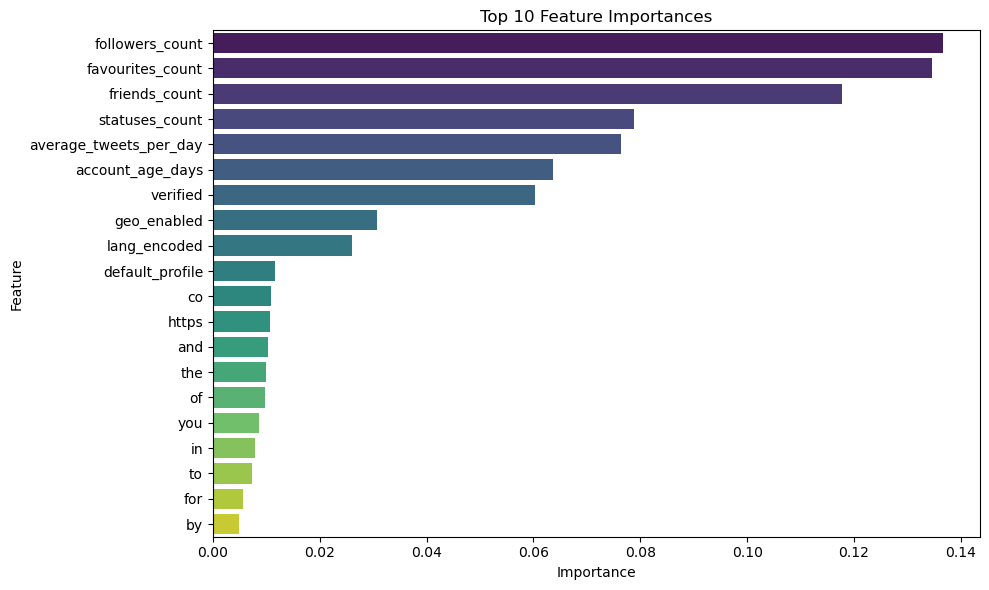

In [9]:
indices = np.argsort(feature_importance)[::-1][:20]
top_feature_names = [all_feature_names[i] for i in indices]
top_feature_values = feature_importance[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feature_values, y=top_feature_names, orient='h', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [10]:
all_feature_names

['default_profile',
 'default_profile_image',
 'favourites_count',
 'followers_count',
 'friends_count',
 'geo_enabled',
 'statuses_count',
 'verified',
 'average_tweets_per_day',
 'account_age_days',
 'lang_encoded',
 'about',
 'account',
 'actor',
 'all',
 'am',
 'an',
 'and',
 'are',
 'artist',
 'as',
 'at',
 'author',
 'be',
 'business',
 'but',
 'by',
 'can',
 'check',
 'co',
 'com',
 'come',
 'de',
 'designer',
 'director',
 'do',
 'don',
 'editor',
 'en',
 'fan',
 'father',
 'follow',
 'for',
 'former',
 'founder',
 'from',
 'gmail',
 'good',
 'have',
 'he',
 'her',
 'here',
 'host',
 'https',
 'husband',
 'ig',
 'in',
 'instagram',
 'is',
 'it',
 'just',
 'la',
 'life',
 'like',
 'live',
 'love',
 'lover',
 'make',
 'me',
 'media',
 'mom',
 'more',
 'music',
 'my',
 'new',
 'news',
 'no',
 'not',
 'now',
 'of',
 'official',
 'on',
 'one',
 'or',
 'out',
 'own',
 'people',
 'producer',
 'proud',
 'she',
 'sports',
 'that',
 'the',
 'things',
 'this',
 'time',
 'to',
 'tv',
 'twe